**Socioeconomic Factors EDA**

In [0]:
from pyspark.sql.functions import *
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
bucket_dir = 'gs://pstat135-voter-file/VM2Uniform/'
AK_df_karina= spark.read.parquet(bucket_dir + 'VM2Uniform--AK--2021-02-03')
CA_df_karina = spark.read.parquet(bucket_dir + 'VM2Uniform--CA--2021-05-02')

In [0]:
# Let's look at the number of columns and rows in the AK dataframe
print("Number of Rows:    ", AK_df_karina.count(), \
      "\nNumber of Columns: ", len(AK_df_karina.columns))

Number of Rows:     548259 
Number of Columns:  726


In [0]:
small_df = AK_df_karina.select('Parties_Description', 'CommercialData_EstimatedHHIncome', 'Ethnic_Description', 'Voters_gender', 'CommercialData_EstHomeValue', 'CommercialData_Education', 'Voters_age', 'CommercialData_OccupationGroup')
small_df = small_df.toPandas()
small_df.head(10)

,Parties_Description,CommercialData_EstimatedHHIncome,Ethnic_Description,Voters_gender,CommercialData_EstHomeValue,CommercialData_Education,Voters_age,CommercialData_OccupationGroup
0,Non-Partisan,$75000-99999,German,M,$325000,Grad Degree - Extremely Likely,70,Technical: Computers/Math and Architect/Engine...
1,Unknown,$125000-149999,Scots,F,$277304,None,None,None
2,Democratic,$125000-149999,French,F,$375000,None,72,None
3,Non-Partisan,$100000-124999,Dutch (Netherlands),M,$180705,Grad Degree - Likely,59,Other
4,Democratic,$75000-99999,English/Welsh,F,$312258,Bach Degree - Extremely Likely,51,Professional: Legal/Education and Health Practiti
5,Non-Partisan,$75000-99999,English/Welsh,M,$312258,Some College -Extremely Likely,62,Professional: Legal/Education and Health Practiti
6,Unknown,$125000-149999,English/Welsh,F,$299344,Bach Degree - Likely,37,Professional: Legal/Education and Health Practiti
7,Unknown,$250000+,English/Welsh,M,$137500,Bach Degree - Likely,72,Technical: Computers/Math and Architect/Engine...
8,Unknown,$125000-149999,English/Welsh,F,$299344,HS Diploma - Extremely Likely,76,Retired
9,Unknown,$125000-149999,English/Welsh,M,$299344,Some College - Likely,77,Retired


In [0]:
# Number of Distinct Cities
AK_df_karina.select(countDistinct('Residence_Addresses_City')).show()

# Number of Distinct Counties
AK_df_karina.select(countDistinct('County').alias("Number_of_Counties")).show()

# Number of Voters per each Distinct County
AK_votes_per_county = AK_df_karina.groupBy('County') \
    .agg(countDistinct('LALVOTERID').alias("Number_Voters")) \
    .sort(desc("Number_Voters"))
AK_votes_per_county.show(truncate=False)

# Number of Distinct Parties
AK_df_karina.select(countDistinct('Parties_Description').alias("Number_of_Parties")).show()

# Number of Voters per each Distinct Party
AK_votes_per_party = AK_df_karina.groupBy('Parties_Description') \
    .agg(countDistinct('LALVOTERID').alias("Number_Voters")) \
    .sort(desc("Number_Voters"))
AK_votes_per_party.show(truncate=False)

# Number of Voters per each Distinct Party in each Distinct County
AK_votes_per_partycounty = AK_df_karina.groupBy('County', 'Parties_Description') \
    .agg(countDistinct('LALVOTERID').alias("Number_Voters")) \
    .sort(desc("Number_Voters"))
AK_votes_per_partycounty.show(truncate=False)

+----------------------------------------+
|count(DISTINCT Residence_Addresses_City)|
+----------------------------------------+
|                                    2705|
+----------------------------------------+

+------------------+
|Number_of_Counties|
+------------------+
|                29|
+------------------+

+---------------------+-------------+
|County               |Number_Voters|
+---------------------+-------------+
|ANCHORAGE            |218565       |
|MATANUSKA SUSITNA    |82135        |
|FAIRBANKS NORTH STAR |69054        |
|KENAI PENINSULA      |49094        |
|JUNEAU               |25984        |
|KETCHIKAN GATEWAY    |11327        |
|BETHEL               |11296        |
|KODIAK ISLAND        |9145         |
|VALDEZ CORDOVA       |8122         |
|SITKA                |6933         |
|NOME                 |6403         |
|SOUTHEAST FAIRBANKS  |5779         |
|NORTH SLOPE          |4893         |
|KUSILVAK             |4801         |
|NORTHWEST ARCTIC     |4572     

**Distribution of Data**

In [0]:
# Number of Voters per each Distinct County
AK_votes_per_county_df = AK_votes_per_county.toPandas()

# Number of Voters per each Distinct Party
AK_votes_per_party_df = AK_votes_per_party.toPandas()

# Number of Voters per each Distinct Party in each Distinct County
AK_votes_per_partycounty_df = AK_votes_per_partycounty.toPandas()

**Number of Voters per Each Distinct County**

In [0]:
AK_votes_per_county_df.head(29)

,County,Number_Voters
0,ANCHORAGE,218565
1,MATANUSKA SUSITNA,82135
2,FAIRBANKS NORTH STAR,69054
3,KENAI PENINSULA,49094
4,JUNEAU,25984
5,KETCHIKAN GATEWAY,11327
6,BETHEL,11296
7,KODIAK ISLAND,9145
8,VALDEZ CORDOVA,8122
9,SITKA,6933


As you can see from the chart above there are around 6 big counties in Alaska, determine by more than 10,000 people. The rest of the counties are extremely small averaging around 3000 people, which is significantly less than most other states.

**Barplot of voters per each county**

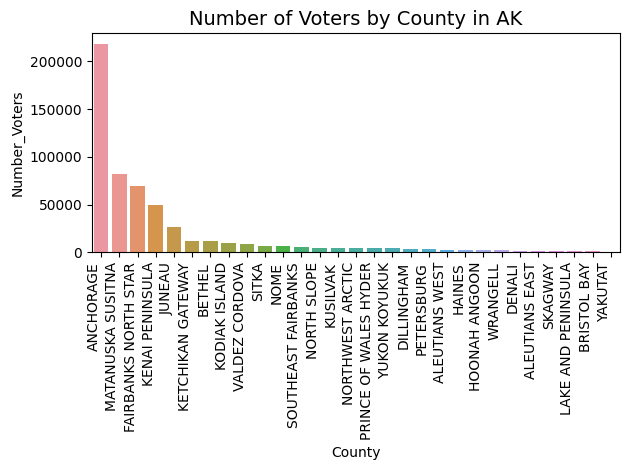

In [0]:
ax1 = sns.barplot(data = AK_votes_per_county_df, \
            x = 'County', \
            y = 'Number_Voters')

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha="right")
ax1.set_title("Number of Voters by County in AK", fontsize=14)
plt.tight_layout()
plt.show()

This visualization makes the descrepancy between Anchorage and the other counties very clear.

**Party Discrepancy in the top 10 counties**

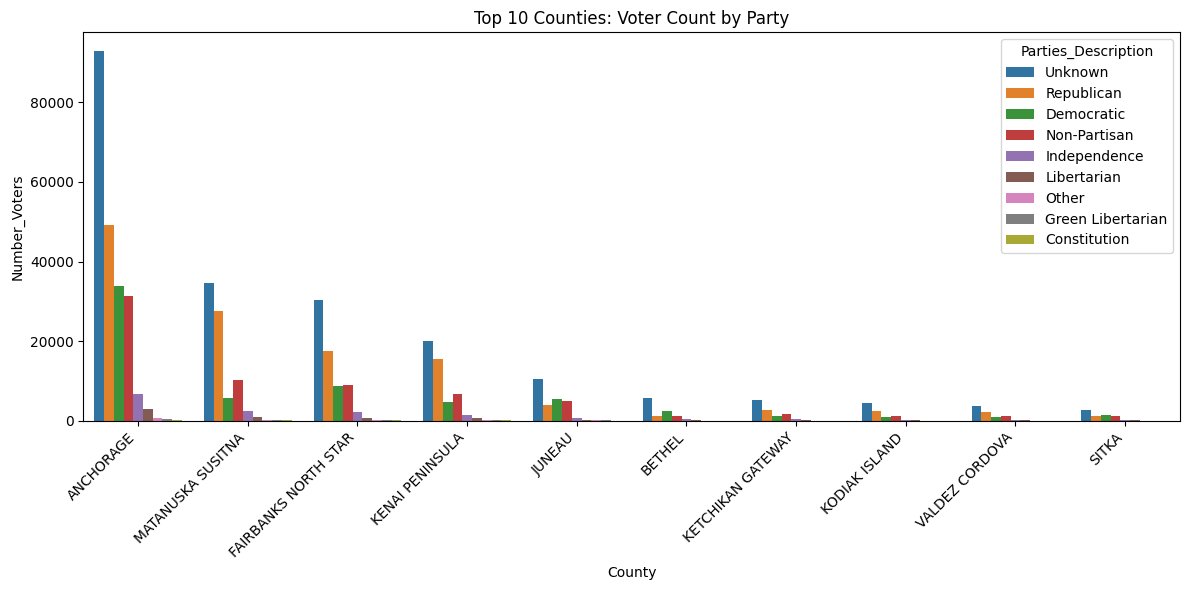

In [0]:
top_counties = (
    AK_votes_per_partycounty_df.groupby("County")["Number_Voters"]
    .sum().nlargest(10).index
)

filtered_df = AK_votes_per_partycounty_df[
    AK_votes_per_partycounty_df["County"].isin(top_counties)
]

plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=filtered_df,
    x="County",
    y="Number_Voters",
    hue="Parties_Description"
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.title("Top 10 Counties: Voter Count by Party")
plt.tight_layout()
plt.show()

Across the top 10 counties other than unknown the most common party is Republican.

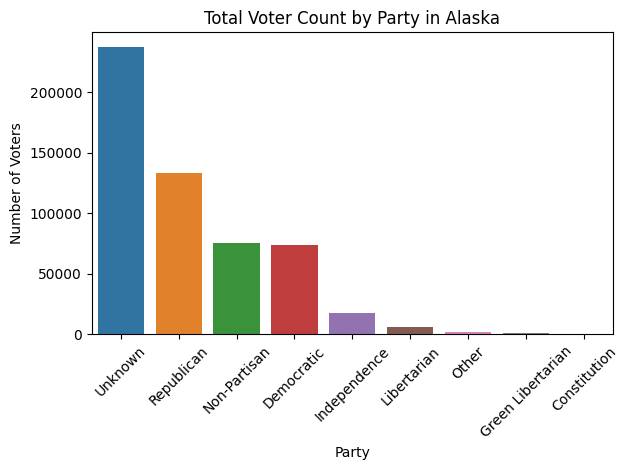

In [0]:
party_counts = small_df['Parties_Description'].value_counts().reset_index()
party_counts.columns = ['Parties_Description', 'Voter_Count']

sns.barplot(data=party_counts, x='Parties_Description', y='Voter_Count')
plt.xticks(rotation=45)
plt.title('Total Voter Count by Party in Alaska')
plt.ylabel('Number of Voters')
plt.xlabel('Party')
plt.tight_layout()
plt.show()


**Party Distribution by Household Income**

In [0]:
# Find the midpoint of each income range
def income_to_midpoint(income_str):
    if pd.isna(income_str):
        return np.nan
    income_str = income_str.replace("$", "").replace(",", "").strip()
    
    if "+" in income_str:
        return float(income_str.replace("+", ""))
    
    if "-" in income_str:
        try:
            lower, upper = income_str.split("-")
            return (float(lower) + float(upper)) / 2
        except:
            return np.nan

    # Catch values like "150000" without "-"
    try:
        return float(income_str)
    except:
        return np.nan

# Apply conversion
small_df['Estimated_HHIncome_midpoint'] = small_df['CommercialData_EstimatedHHIncome'].apply(income_to_midpoint)
small_df['Estimated_HomeValue_midpoint'] = small_df['CommercialData_EstHomeValue'].apply(income_to_midpoint)
filtered_df = small_df[
    small_df['Parties_Description'].isin(['Non-Partisan', 'Unknown', 'Democratic', 'Republican'])
]

/root/.ipykernel/1060/command-6721689964037841-3549166527:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(data=small_df, x='Parties_Description', y='Estimated_HHIncome_midpoint', ci='sd')


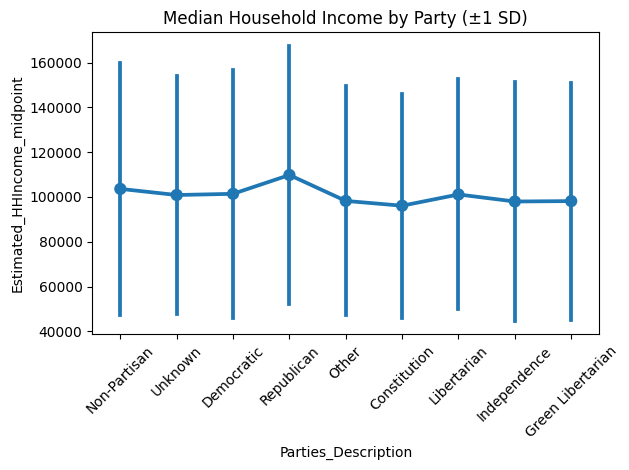

In [0]:
sns.pointplot(data=small_df, x='Parties_Description', y='Estimated_HHIncome_midpoint', ci='sd')
plt.xticks(rotation=45)
plt.title('Median Household Income by Party (±1 SD)')
plt.tight_layout()
plt.show()

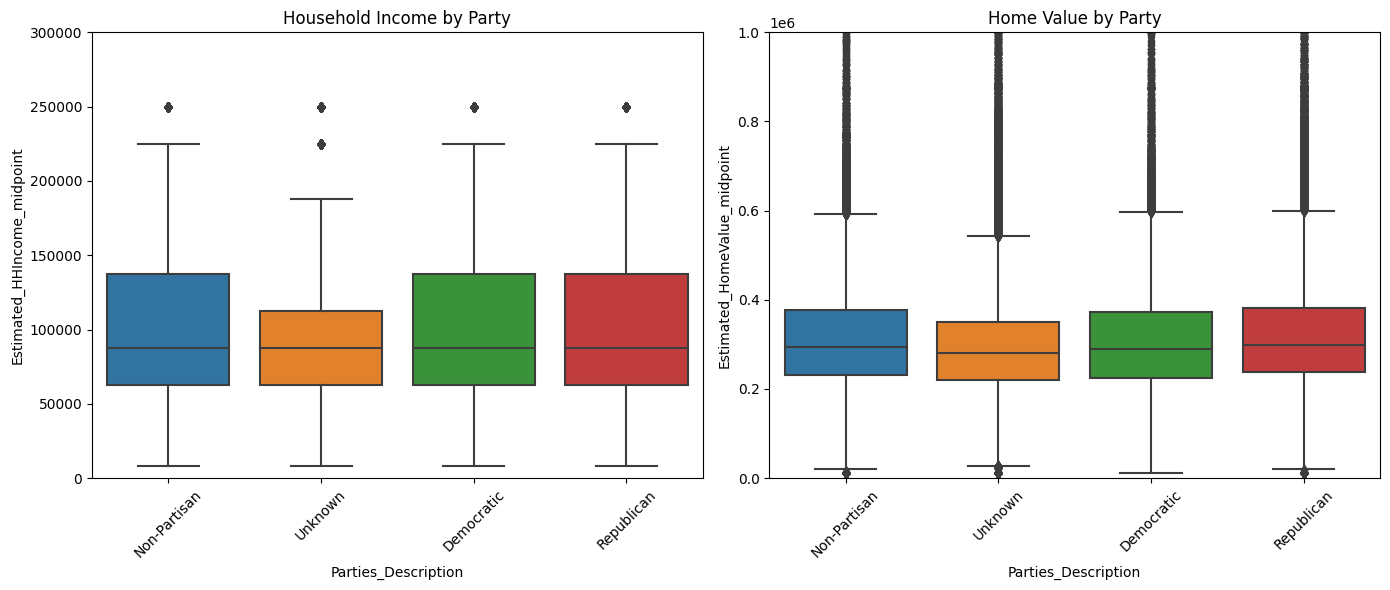

In [0]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# Income
sns.boxplot(data=filtered_df, x='Parties_Description', y='Estimated_HHIncome_midpoint', ax=axs[0])
axs[0].set_title('Household Income by Party')
axs[0].tick_params(axis='x', rotation=45)
axs[0].set_ylim(0, 300000)  # Adjust as needed to focus on bottom portion

# Home Value
sns.boxplot(data=filtered_df, x='Parties_Description', y='Estimated_HomeValue_midpoint', ax=axs[1])
axs[1].set_title('Home Value by Party')
axs[1].tick_params(axis='x', rotation=45)
axs[1].set_ylim(0, 1000000)  # Adjust this too

plt.tight_layout()
plt.show()

The income and home value spread between the Non-Partisan, Democratic, and Republican parties are very similar. The unknown party is skewed slightly lower. 

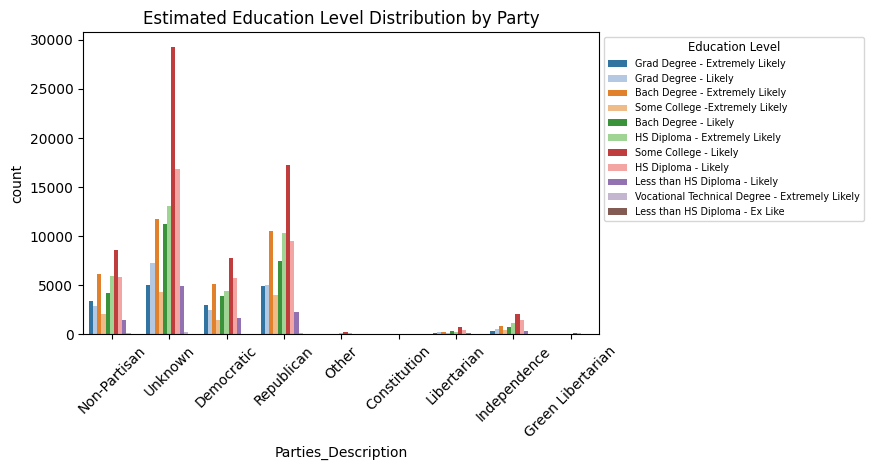

In [0]:
palette = sns.color_palette("tab20", n_colors=small_df['CommercialData_Education'].nunique())

sns.countplot(data=small_df, x='Parties_Description', hue='CommercialData_Education', palette = palette)
plt.xticks(rotation=45)
plt.title('Estimated Education Level Distribution by Party')
plt.tight_layout()
plt.legend(title='Education Level', fontsize='x-small', title_fontsize='small', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

For the four most common parties Non-Partisan, Democratic, and Republican the most common estimated highest education level achieved is "Some College- Likely", with "HS Disploma- Likely" being the next most common. 

**Occupations Distributed by Party**

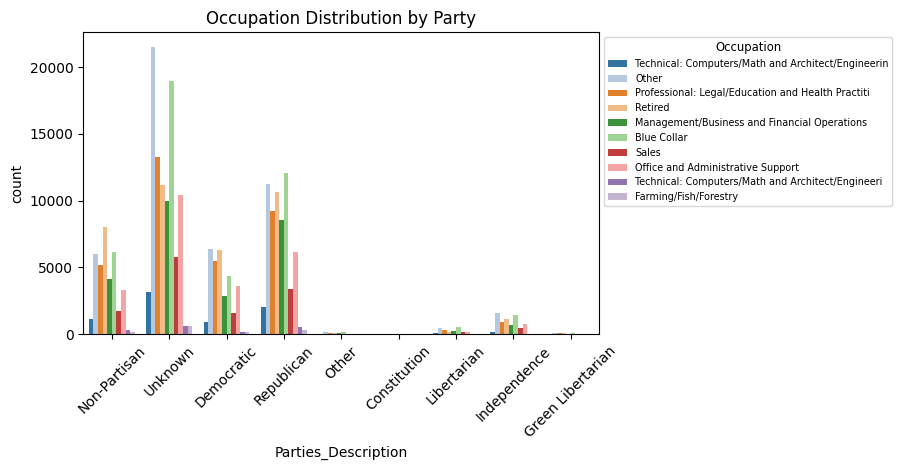

In [0]:
palette = sns.color_palette("tab20", n_colors=small_df['CommercialData_OccupationGroup'].nunique())

sns.countplot(data=small_df, x='Parties_Description', hue='CommercialData_OccupationGroup', palette = palette)
plt.xticks(rotation=45)
plt.title('Occupation Distribution by Party')
plt.tight_layout()
plt.legend(title='Occupation', fontsize='x-small', title_fontsize='small', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

The most common occupation for the most common parties was Other or Blue Collar.

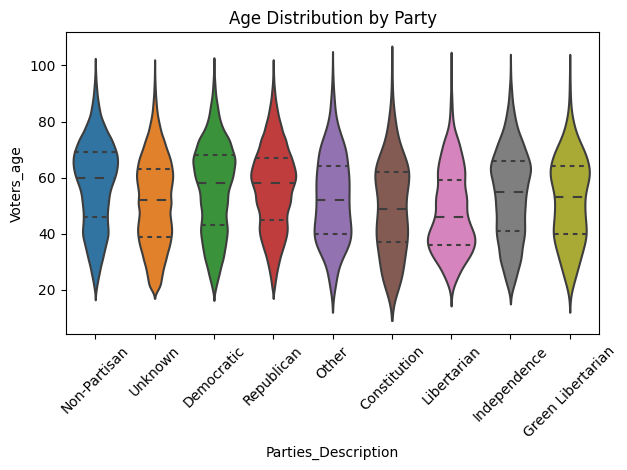

In [0]:
small_df['Voters_age'] = pd.to_numeric(small_df['Voters_age'], errors='coerce')
sns.violinplot(data=small_df, x='Parties_Description', y='Voters_age', inner='quartile')
plt.xticks(rotation=45)
plt.title('Age Distribution by Party')
plt.tight_layout()
plt.show()

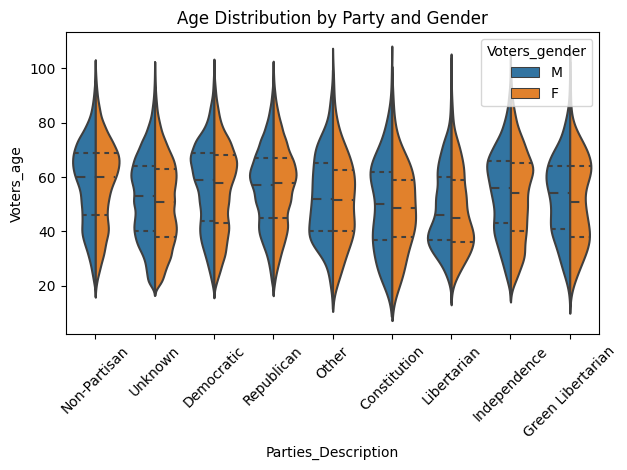

In [0]:
sns.violinplot(
    data=small_df,
    x='Parties_Description',
    y='Voters_age',
    hue='Voters_gender',
    split=True,
    inner='quartile'
)
plt.xticks(rotation=45)
plt.title('Age Distribution by Party and Gender')
plt.tight_layout()
plt.show()

From the many visualizations above we can see that the top most common parties are Unknown and Republican. Out of the socioeconomic factors we looked at: 'Parties_Description', 'CommercialData_EstimatedHHIncome', 'Ethnic_Description', 'Voters_gender', 'CommercialData_EstHomeValue', 'CommercialData_Education', 'Voters_age', 'CommercialData_OccupationGroup', it seems that no one specific factor predicts an individual's political party over another factor. A few trends we noticed are that the unknown category seems to have younger voters than the non-partisan, democratic, and republican parties. Additionally, Republicans seemed to have a slightly higher median household income than the other parties. 